In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, time
import datetime
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
# fixar random seed para se puder reproduzir os resultados
seed = 9
np.random.seed(seed)

# Etapa 1 - preparar o dataset

In [17]:
'''
fazer o download da sequencias do valor das ações da google GOOGL stock data (fonte yahoo.com)
dataset:
http://chart.finance.yahoo.com/table.csv?s=GOOGL&a=11&b=15&c=2011&d=29&e=10&f=2016&g=d&ignore=.csv
A função get_stock_data é generica para ir buscar dados à yahoo.com
trata-se uma tabela com: ['Date','Open','High','Low','Close','Volume','Adj Close']
Vamos śo utilizar os campos ['Open','High','Close']
'''
def get_stock_data(stock_name, normalized=0,file_name=None):
    if not file_name:
        file_name = 'http://chart.finance.yahoo.com/table.csv?s=%s&a=11&b=15&c=2011&d=29&e=10&f=2016&g=d&ignore=.csv' % stock_name
    col_names = ['Date','Open','High','Low','Close','Volume','Adj Close']
    stocks = pd.read_csv(file_name, header=0, names=col_names) #fica numa especie de tabela exactamente como estava no csv (1350 linhas,7 colunas)
    df = pd.DataFrame(stocks) #neste caso não vai fazer nada
    date_split = df['Date'].str.split('-').str #não vai servir para nada
    df['Year'], df['Month'], df['Day'] = date_split #não vai servir para nada
    df["Volume"] = df["Volume"] / 10000 #não vai servir para nada
    df.drop(df.columns[[0,3,5,6, 7,8,9]], axis=1, inplace=True) #vou só ficar com as colunas 1,2,4
    return df

In [18]:
def load_GOOGL_stock_dataset():
    stock_name = 'GOOGL'
    return get_stock_data(stock_name, 0, 'table.csv')

def pre_processar_GOOGL_stock_dataset(df):
    df['High'] = df['High'] / 100
    df['Open'] = df['Open'] / 100
    df['Close'] = df['Close'] / 100
    return df

# Visualizar os top registos da tabela
def visualize_GOOGL():
    df = load_GOOGL_stock_dataset()
    print('### Antes do pré-processamento ###')
    print(df.head()) #mostra só os primeiros 5 registos
    df = pre_processar_GOOGL_stock_dataset(df)
    print('### Após o pré-processamento ###')
    print(df.head())

In [19]:
#função load_data do lstm.py configurada para aceitar qualquer número de parametros
#o último atributo é que fica como label (resultado)
#stock é um dataframe do pandas (uma especie de dicionario + matriz)
#seq_len é o tamanho da janela a ser utilizada na serie temporal
def load_data(df_dados, janela):
    qt_atributos = len(df_dados.columns)
    mat_dados = df_dados.as_matrix() #converter dataframe para matriz (lista com lista de cada registo)
    tam_sequencia = janela + 1
    res = []
    for i in range(len(mat_dados) - tam_sequencia): #numero de registos - tamanho da sequencia
        res.append(mat_dados[i: i + tam_sequencia])
    res = np.array(res) #dá como resultado um np com uma lista de matrizes (janela deslizante ao longo da serie)
    qt_casos_treino = int(round(0.9 * res.shape[0])) #90% passam a ser casos de treino
    train = res[:qt_casos_treino, :]
    x_train = train[:, :-1] #menos um registo pois o ultimo registo é o registo a seguir à janela
    y_train = train[:, -1][:,-1] #para ir buscar o último atributo para a lista dos labels
    x_test = res[qt_casos_treino:, :-1]
    y_test = res[qt_casos_treino:, -1][:,-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], qt_atributos))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], qt_atributos))
    return [x_train, y_train, x_test, y_test]

# Etapa 2 - Definir a topologia da rede (arquitectura do modelo) e compilar '''

In [20]:
def build_model2(janela):
    model = Sequential()
    model.add(LSTM(128, input_shape=(janela, 3), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, input_shape=(janela, 3), return_sequences=False))
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="linear", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

In [21]:
#imprime um grafico com os valores de teste e com as correspondentes tabela de previsões
def print_series_prediction(y_test,predic):
    diff=[]
    racio=[]
    for i in range(len(y_test)): #para imprimir tabela de previsoes
        racio.append( (y_test[i]/predic[i])-1)
        diff.append( abs(y_test[i]- predic[i]))
        print('valor: %f ---> Previsão: %f Diff: %f Racio: %f' % (y_test[i],predic[i], diff[i], racio[i]))
    plt.plot(y_test,color='blue', label='y_test')
    plt.plot(predic,color='red', label='prediction') #este deu uma linha em branco
    plt.plot(diff,color='green', label='diff')
    plt.plot(racio,color='yellow', label='racio')
    plt.legend(loc='upper left')
    plt.show()

In [27]:
def LSTM_utilizando_GOOGL_data():
    df = load_GOOGL_stock_dataset()
    df = pre_processar_GOOGL_stock_dataset(df)
    print("df", df.shape)
    janela = 22 #tamanho da Janela deslizante
    X_train, y_train, X_test, y_test = load_data(df[::-1], janela)# o df[::-1] é o df por ordem inversa
    print("X_train", X_train.shape)
    print("y_train", y_train.shape)
    print("X_test", X_test.shape)
    print("y_test", y_test.shape)
    #model = build_model(janela)
    model = build_model2(janela)
    #model.fit(X_train, y_train, batch_size=512, epochs=500, validation_split=0.1, verbose=1)
    model.fit(X_train, y_train, batch_size=512, epochs=500, validation_split=0.1, verbose=1)
    #print_model(model,"lstm_model.png")
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    print(model.metrics_names)
    p = model.predict(X_test)
    predic = np.squeeze(np.asarray(p)) #para transformar uma matriz de uma coluna e n linhas em 
    #um np array de n elementos
    print_series_prediction(y_test,predic)
    ''' 
    MSE- (Mean square error), RMSE- (root mean square error) –
    o significado de RMSE depende do range da label. para o mesmo range menor é melhor.
    '''

### Antes do pré-processamento ###
         Open        High       Close
0  929.000000  935.900024  924.520020
1  890.000000  893.380005  891.440002
2  891.390015  892.989990  889.140015
3  882.260010  892.250000  888.840027
4  868.440002  879.960022  878.929993
### Após o pré-processamento ###
     Open    High   Close
0  9.2900  9.3590  9.2452
1  8.9000  8.9338  8.9144
2  8.9139  8.9299  8.8914
3  8.8226  8.9225  8.8884
4  8.6844  8.7996  8.7893
df (1350, 3)
X_train (1194, 22, 3)
y_train (1194,)
X_test (133, 22, 3)
y_test (133,)
Train on 1074 samples, validate on 120 samples
Epoch 1/500
1074/1074 [==============================] - 2s 2ms/step - loss: 54.5862 - acc: 0.0000e+00 - val_loss: 57.5806 - val_acc: 0.0000e+00
Epoch 2/500
1074/1074 [==============================] - 0s 205us/step - loss: 54.1077 - acc: 0.0000e+00 - val_loss: 56.8931 - val_acc: 0.0000e+00
Epoch 3/500
1074/1074 [==============================] - 0s 219us/step - loss: 53.4246 - acc: 0.0000e+00 - val_loss: 55.9843

Epoch 53/500
1074/1074 [==============================] - 0s 224us/step - loss: 3.1085 - acc: 0.0000e+00 - val_loss: 0.3084 - val_acc: 0.0000e+00
Epoch 54/500
1074/1074 [==============================] - 0s 234us/step - loss: 3.1096 - acc: 0.0000e+00 - val_loss: 0.2896 - val_acc: 0.0000e+00
Epoch 55/500
1074/1074 [==============================] - 0s 207us/step - loss: 3.1127 - acc: 0.0000e+00 - val_loss: 0.2729 - val_acc: 0.0000e+00
Epoch 56/500
1074/1074 [==============================] - 0s 209us/step - loss: 3.1170 - acc: 0.0000e+00 - val_loss: 0.2633 - val_acc: 0.0000e+00
Epoch 57/500
1074/1074 [==============================] - 0s 209us/step - loss: 3.1203 - acc: 0.0000e+00 - val_loss: 0.2586 - val_acc: 0.0000e+00
Epoch 58/500
1074/1074 [==============================] - 0s 209us/step - loss: 3.1215 - acc: 0.0000e+00 - val_loss: 0.2608 - val_acc: 0.0000e+00
Epoch 59/500
1074/1074 [==============================] - 0s 209us/step - loss: 3.1204 - acc: 0.0000e+00 - val_loss: 0.2681 

1074/1074 [==============================] - 0s 261us/step - loss: 3.1082 - acc: 0.0000e+00 - val_loss: 0.3409 - val_acc: 0.0000e+00
Epoch 110/500
1074/1074 [==============================] - 0s 258us/step - loss: 3.1083 - acc: 0.0000e+00 - val_loss: 0.3509 - val_acc: 0.0000e+00
Epoch 111/500
1074/1074 [==============================] - 0s 262us/step - loss: 3.1085 - acc: 0.0000e+00 - val_loss: 0.3509 - val_acc: 0.0000e+00
Epoch 112/500
1074/1074 [==============================] - 0s 260us/step - loss: 3.1083 - acc: 0.0000e+00 - val_loss: 0.3391 - val_acc: 0.0000e+00
Epoch 113/500
1074/1074 [==============================] - 0s 265us/step - loss: 3.1082 - acc: 0.0000e+00 - val_loss: 0.3268 - val_acc: 0.0000e+00
Epoch 114/500
1074/1074 [==============================] - 0s 259us/step - loss: 3.1086 - acc: 0.0000e+00 - val_loss: 0.3173 - val_acc: 0.0000e+00
Epoch 115/500
1074/1074 [==============================] - 0s 262us/step - loss: 3.1097 - acc: 0.0000e+00 - val_loss: 0.3170 - val_a

Epoch 165/500
1074/1074 [==============================] - 0s 222us/step - loss: 3.1102 - acc: 0.0000e+00 - val_loss: 0.3720 - val_acc: 0.0000e+00
Epoch 166/500
1074/1074 [==============================] - 0s 225us/step - loss: 3.1093 - acc: 0.0000e+00 - val_loss: 0.3450 - val_acc: 0.0000e+00
Epoch 167/500
1074/1074 [==============================] - 0s 221us/step - loss: 3.1086 - acc: 0.0000e+00 - val_loss: 0.3218 - val_acc: 0.0000e+00
Epoch 168/500
1074/1074 [==============================] - 0s 225us/step - loss: 3.1092 - acc: 0.0000e+00 - val_loss: 0.3201 - val_acc: 0.0000e+00
Epoch 169/500
1074/1074 [==============================] - 0s 227us/step - loss: 3.1091 - acc: 0.0000e+00 - val_loss: 0.3310 - val_acc: 0.0000e+00
Epoch 170/500
1074/1074 [==============================] - 0s 224us/step - loss: 3.1090 - acc: 0.0000e+00 - val_loss: 0.3436 - val_acc: 0.0000e+00
Epoch 171/500
1074/1074 [==============================] - 0s 203us/step - loss: 3.1082 - acc: 0.0000e+00 - val_loss: 

Epoch 221/500
1074/1074 [==============================] - 0s 221us/step - loss: 3.1110 - acc: 0.0000e+00 - val_loss: 0.4190 - val_acc: 0.0000e+00
Epoch 222/500
1074/1074 [==============================] - 0s 215us/step - loss: 3.1160 - acc: 0.0000e+00 - val_loss: 0.4413 - val_acc: 0.0000e+00
Epoch 223/500
1074/1074 [==============================] - 0s 220us/step - loss: 3.1185 - acc: 0.0000e+00 - val_loss: 0.4343 - val_acc: 0.0000e+00
Epoch 224/500
1074/1074 [==============================] - 0s 222us/step - loss: 3.1169 - acc: 0.0000e+00 - val_loss: 0.4167 - val_acc: 0.0000e+00
Epoch 225/500
1074/1074 [==============================] - 0s 199us/step - loss: 3.1141 - acc: 0.0000e+00 - val_loss: 0.3772 - val_acc: 0.0000e+00
Epoch 226/500
1074/1074 [==============================] - 0s 227us/step - loss: 3.1094 - acc: 0.0000e+00 - val_loss: 0.3474 - val_acc: 0.0000e+00
Epoch 227/500
1074/1074 [==============================] - 0s 230us/step - loss: 3.1079 - acc: 0.0000e+00 - val_loss: 

Epoch 277/500
1074/1074 [==============================] - 0s 330us/step - loss: 3.1091 - acc: 0.0000e+00 - val_loss: 0.3457 - val_acc: 0.0000e+00
Epoch 278/500
1074/1074 [==============================] - 0s 302us/step - loss: 3.1080 - acc: 0.0000e+00 - val_loss: 0.3275 - val_acc: 0.0000e+00
Epoch 279/500
1074/1074 [==============================] - 0s 315us/step - loss: 3.1085 - acc: 0.0000e+00 - val_loss: 0.3149 - val_acc: 0.0000e+00
Epoch 280/500
1074/1074 [==============================] - 0s 308us/step - loss: 3.1096 - acc: 0.0000e+00 - val_loss: 0.3286 - val_acc: 0.0000e+00
Epoch 281/500
1074/1074 [==============================] - 0s 307us/step - loss: 3.1079 - acc: 0.0000e+00 - val_loss: 0.3597 - val_acc: 0.0000e+00
Epoch 282/500
1074/1074 [==============================] - 0s 304us/step - loss: 3.1089 - acc: 0.0000e+00 - val_loss: 0.3815 - val_acc: 0.0000e+00
Epoch 283/500
1074/1074 [==============================] - 0s 330us/step - loss: 3.1103 - acc: 0.0000e+00 - val_loss: 

Epoch 333/500
1074/1074 [==============================] - 0s 244us/step - loss: 3.1082 - acc: 0.0000e+00 - val_loss: 0.3462 - val_acc: 0.0000e+00
Epoch 334/500
1074/1074 [==============================] - 0s 283us/step - loss: 3.1083 - acc: 0.0000e+00 - val_loss: 0.3487 - val_acc: 0.0000e+00
Epoch 335/500
1074/1074 [==============================] - 0s 248us/step - loss: 3.1081 - acc: 0.0000e+00 - val_loss: 0.3588 - val_acc: 0.0000e+00
Epoch 336/500
1074/1074 [==============================] - 0s 238us/step - loss: 3.1085 - acc: 0.0000e+00 - val_loss: 0.3608 - val_acc: 0.0000e+00
Epoch 337/500
1074/1074 [==============================] - 0s 252us/step - loss: 3.1091 - acc: 0.0000e+00 - val_loss: 0.3591 - val_acc: 0.0000e+00
Epoch 338/500
1074/1074 [==============================] - 0s 254us/step - loss: 3.1082 - acc: 0.0000e+00 - val_loss: 0.3737 - val_acc: 0.0000e+00
Epoch 339/500
1074/1074 [==============================] - 0s 255us/step - loss: 3.1096 - acc: 0.0000e+00 - val_loss: 

Epoch 389/500
1074/1074 [==============================] - 0s 229us/step - loss: 3.1164 - acc: 0.0000e+00 - val_loss: 0.4248 - val_acc: 0.0000e+00
Epoch 390/500
1074/1074 [==============================] - 0s 227us/step - loss: 3.1155 - acc: 0.0000e+00 - val_loss: 0.4131 - val_acc: 0.0000e+00
Epoch 391/500
1074/1074 [==============================] - 0s 217us/step - loss: 3.1130 - acc: 0.0000e+00 - val_loss: 0.3904 - val_acc: 0.0000e+00
Epoch 392/500
1074/1074 [==============================] - 0s 203us/step - loss: 3.1107 - acc: 0.0000e+00 - val_loss: 0.3682 - val_acc: 0.0000e+00
Epoch 393/500
1074/1074 [==============================] - 0s 206us/step - loss: 3.1091 - acc: 0.0000e+00 - val_loss: 0.3600 - val_acc: 0.0000e+00
Epoch 394/500
1074/1074 [==============================] - 0s 234us/step - loss: 3.1086 - acc: 0.0000e+00 - val_loss: 0.3706 - val_acc: 0.0000e+00
Epoch 395/500
1074/1074 [==============================] - 0s 230us/step - loss: 3.1094 - acc: 0.0000e+00 - val_loss: 

Epoch 445/500
1074/1074 [==============================] - 0s 238us/step - loss: 3.1094 - acc: 0.0000e+00 - val_loss: 0.3338 - val_acc: 0.0000e+00
Epoch 446/500
1074/1074 [==============================] - 0s 233us/step - loss: 3.1089 - acc: 0.0000e+00 - val_loss: 0.3617 - val_acc: 0.0000e+00
Epoch 447/500
1074/1074 [==============================] - 0s 270us/step - loss: 3.1087 - acc: 0.0000e+00 - val_loss: 0.3634 - val_acc: 0.0000e+00
Epoch 448/500
1074/1074 [==============================] - 0s 256us/step - loss: 3.1092 - acc: 0.0000e+00 - val_loss: 0.3613 - val_acc: 0.0000e+00
Epoch 449/500
1074/1074 [==============================] - 0s 251us/step - loss: 3.1079 - acc: 0.0000e+00 - val_loss: 0.3272 - val_acc: 0.0000e+00
Epoch 450/500
1074/1074 [==============================] - 0s 242us/step - loss: 3.1128 - acc: 0.0000e+00 - val_loss: 0.2915 - val_acc: 0.0000e+00
Epoch 451/500
1074/1074 [==============================] - 0s 243us/step - loss: 3.1134 - acc: 0.0000e+00 - val_loss: 

Train Score: 2.84 MSE (1.69 RMSE)
Test Score: 1.41 MSE (1.19 RMSE)
['loss', 'acc']
valor: 8.068400 ---> Previsão: 7.111453 Diff: 0.956948 Racio: 0.134564
valor: 8.214900 ---> Previsão: 7.111453 Diff: 1.103447 Racio: 0.155165
valor: 8.268400 ---> Previsão: 7.111453 Diff: 1.156948 Racio: 0.162688
valor: 8.216300 ---> Previsão: 7.111453 Diff: 1.104847 Racio: 0.155362
valor: 8.240600 ---> Previsão: 7.111453 Diff: 1.129147 Racio: 0.158779
valor: 8.357400 ---> Previsão: 7.111453 Diff: 1.245947 Racio: 0.175203
valor: 8.285500 ---> Previsão: 7.111453 Diff: 1.174047 Racio: 0.165092
valor: 8.221000 ---> Previsão: 7.111453 Diff: 1.109547 Racio: 0.156023
valor: 8.173500 ---> Previsão: 7.111453 Diff: 1.062047 Racio: 0.149343
valor: 8.195600 ---> Previsão: 7.111453 Diff: 1.084147 Racio: 0.152451
valor: 8.099000 ---> Previsão: 7.111453 Diff: 0.987548 Racio: 0.138867
valor: 8.054800 ---> Previsão: 7.111453 Diff: 0.943347 Racio: 0.132652
valor: 7.884200 ---> Previsão: 7.111453 Diff: 0.772747 Racio: 0.1

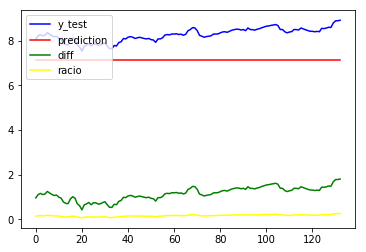

In [28]:
if __name__ == '__main__':
    visualize_GOOGL()
    LSTM_utilizando_GOOGL_data()

In [29]:
print(model.summary())

NameError: name 'model' is not defined